In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

***Read Data***

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

***Visualize the data***

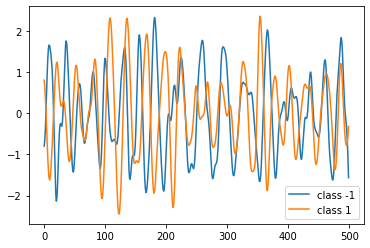

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

***Standardize the data***

In [4]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [5]:
num_classes = len(np.unique(y_train))

In [6]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [7]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

***Build a model***

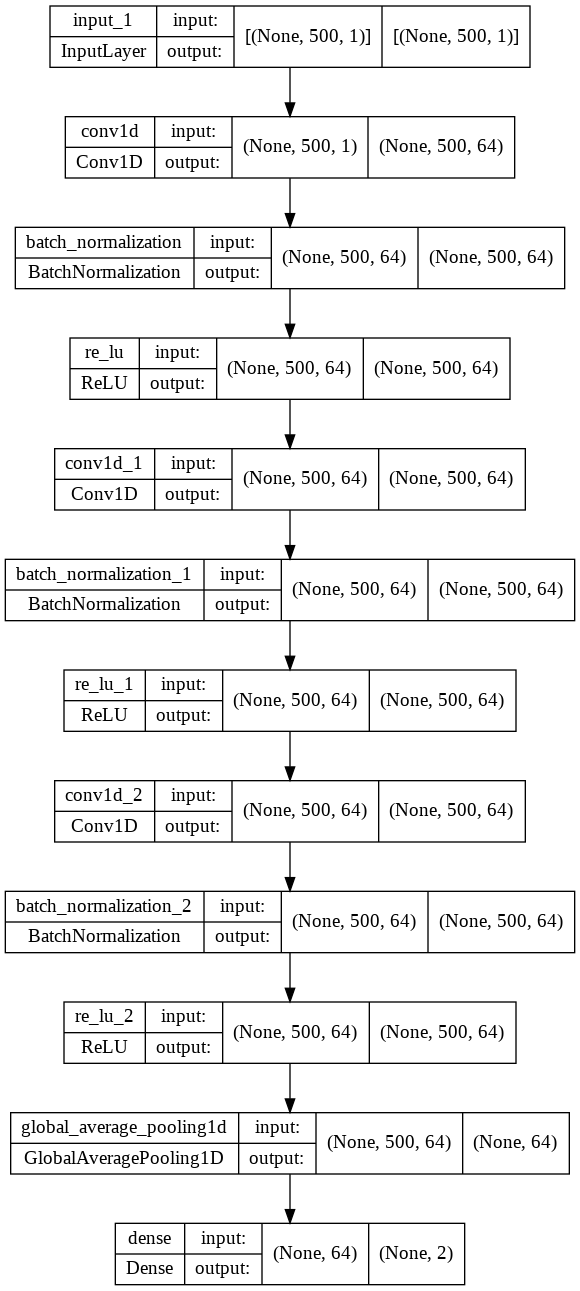

In [8]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

***Train the model***

In [11]:
epochs = 120
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/120
90/90 [==============================] - 13s 131ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.4997 - val_sparse_categorical_accuracy: 0.7822 - lr: 0.0010
Epoch 2/120
90/90 [==============================] - 11s 124ms/step - loss: 0.1128 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.2794 - val_sparse_categorical_accuracy: 0.8641 - lr: 0.0010
Epoch 3/120
90/90 [==============================] - 11s 124ms/step - loss: 0.1183 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.7639 - val_sparse_categorical_accuracy: 0.6893 - lr: 0.0010
Epoch 4/120
90/90 [==============================] - 11s 126ms/step - loss: 0.1199 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.2935 - val_sparse_categorical_accuracy: 0.8585 - lr: 0.0010
Epoch 5/120
90/90 [==============================] - 12s 130ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.3925 - val_sparse_categorical_accuracy: 0.8128 - lr: 0.0010
Epoch 6/120
90/90 [======

***Evaluate model on test data***

In [12]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 27ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9697
Test accuracy 0.9696969985961914
Test loss 0.09056290984153748


***Plot the model's training and validation loss***

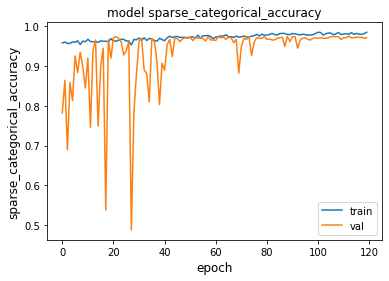

In [13]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()